<a href="https://colab.research.google.com/github/Vipul-Jirge/My_Experiments_with_CV_DL/blob/main/fruit_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import shutil
import contextlib
import math
import statistics as st

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import regularizers

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

2.8.2


{'full': 33, 'full_occlude': 25, 'partial_occlude': 19}
24


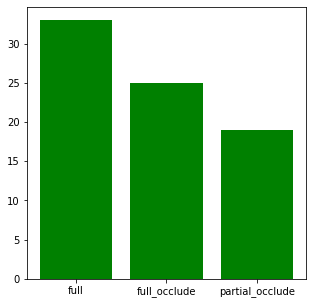

In [3]:
curr_dir = r"/content/drive/MyDrive/Assignment_Uploads/Fruit_classify"

train_dir = os.path.join(curr_dir, 'train')
test_dir = os.path.join(curr_dir, 'test')

# Get count of JPGs in each sub-folder & plot 
class_names = os.listdir(os.path.join(curr_dir,train_dir))

train_img_count = {i : len(glob.glob1(os.path.join(curr_dir, train_dir, i), '*.jpg')) for i in class_names}
plt.figure(figsize=(5,5))
plt.bar(list(train_img_count.keys()), train_img_count.values(), color='g')

test_img_count = len(glob.glob1(os.path.join(curr_dir, test_dir), '*.jpg'))
  
print(train_img_count)
print(test_img_count)

In [4]:
# Set all the parameters
batch_size = 64
IMG_SIZE = (150, 150, 3)
test_train_split = 0.2

In [5]:
# Create train - test DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=test_train_split,
    subset="training",
    seed=123,
    image_size=IMG_SIZE[:2],
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=test_train_split,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE[:2],
    batch_size=batch_size)

class_names = train_ds.class_names

# print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

Found 77 files belonging to 3 classes.
Using 62 files for training.
Found 77 files belonging to 3 classes.
Using 15 files for validation.


In [6]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  # tf.keras.layers.RandomBrightness(0.3, value_range=(0, 1))
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation((-0.2,0.2),(-0.2,0.2),fill_mode='nearest')
])


In [8]:
# Setup CNN Architecture 

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=IMG_SIZE),
  data_augmentation,
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

optimizer='adam'
metrics=['accuracy']

model.compile(optimizer = optimizer,
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=metrics)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 128)      

In [9]:
epochs = 50

callback = keras.callbacks.EarlyStopping(
    monitor='accuracy', # accuracy, loss,val_accuracy, val_loss, 
    min_delta=0,
    patience=8,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/50
1/1 [==============================] - 18s 18s/step - loss: 1.5770 - accuracy: 0.2258 - val_loss: 7.4747 - val_accuracy: 0.3333
Epoch 2/50
1/1 [==============================] - 0s 205ms/step - loss: 172.8575 - accuracy: 0.4516 - val_loss: 3.4792 - val_accuracy: 0.2000
Epoch 3/50
1/1 [==============================] - 0s 169ms/step - loss: 80.3101 - accuracy: 0.2581 - val_loss: 1.5355 - val_accuracy: 0.2000
Epoch 4/50
1/1 [==============================] - 0s 157ms/step - loss: 16.6259 - accuracy: 0.2581 - val_loss: 2.0348 - val_accuracy: 0.3333
Epoch 5/50
1/1 [==============================] - 0s 159ms/step - loss: 23.9463 - accuracy: 0.4516 - val_loss: 2.1766 - val_accuracy: 0.4667
Epoch 6/50
1/1 [==============================] - 0s 165ms/step - loss: 26.4875 - accuracy: 0.3710 - val_loss: 2.4132 - val_accuracy: 0.4000
Epoch 7/50
1/1 [==============================] - 0s 160ms/step - loss: 23.5260 - accuracy: 0.4194 - val_loss: 2.0632 - val_accuracy: 0.4000
Epoch 8/50
1/1

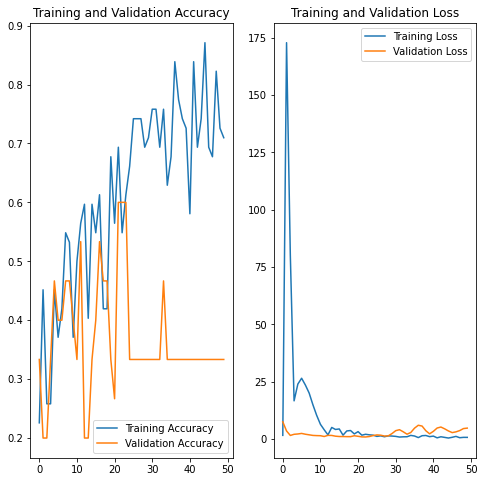

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir)
# yhat = model.predict(X)
# import cv2_imshow
# img = cv2.imread(os.path.join(curr_dir,os.listdir(test_dir)[0]))

# plt.imshow(img)
# history
# print(os.path.join(curr_dir,os.listdir(test_dir)[0]))


/bin/bash: line 0: cd: test_dir: No such file or directory
Found 0 files belonging to 0 classes.


ValueError: ignored